In [1]:
import torch
from torchvision import datasets, transforms as T
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from sklearn.model_selection import train_test_split

In [2]:
data_transforms = {
    'train': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    'test': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
#    'validation': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
}

In [3]:
data_dir = '../Carcinoma_and_others_classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda")

In [4]:
import torchvision.models as models
resnet34 = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [8]:
model_cnn = resnet34.to(device)

#model_cnn = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer = optim.SGD(model_cnn.parameters(), lr=0.1, momentum=0.9)
#lambda1 = lambda epoch:0.65**epoch
#schedular = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.00001)
 

In [9]:
train_loader, test_loader= dataloaders['train'], dataloaders['test']
train_acc=[]
train_loss=[]


def train_model(model, criterion, optimizer):
    running_loss = 0 
    running_corrects = 0 

    model.train()  # 모델을 학습 모드로 설정
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * running_corrects.double() /  len(train_loader.dataset)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    
 
        

In [10]:
test_acc=[]
test_loss=[]

def test_model(model):
 
    best_acc = 0.0
    model.eval()   

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
 
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * running_corrects.double() / len(test_loader.dataset)


    if epoch_acc > best_acc:
        best_acc = epoch_acc

    print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()
    print('Best Test Acc: {:4f}'.format(best_acc))
    test_acc.append(epoch_acc)
    test_loss.append(epoch_loss)
 
 
    return best_acc

In [11]:
num_epochs =  100

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    train_model(model_cnn, criterion, optimizer)
    best_acc = test_model(model_cnn)

Epoch 0/100
----------
train Loss: 10.1893 Acc: 47.6395
test Loss: 5227.7018 Acc: 57.1429

Best Test Acc: 57.142857
Epoch 1/100
----------
train Loss: 2.9177 Acc: 57.9399
test Loss: 0.6433 Acc: 53.8462

Best Test Acc: 53.846154
Epoch 2/100
----------
train Loss: 1.2500 Acc: 54.5064
test Loss: 2.0667 Acc: 42.8571

Best Test Acc: 42.857143
Epoch 3/100
----------
train Loss: 1.2891 Acc: 54.0773
test Loss: 0.8064 Acc: 54.9451

Best Test Acc: 54.945055
Epoch 4/100
----------
train Loss: 0.7657 Acc: 66.9528
test Loss: 1.0194 Acc: 65.9341

Best Test Acc: 65.934066
Epoch 5/100
----------
train Loss: 0.7624 Acc: 62.2318
test Loss: 0.4965 Acc: 84.6154

Best Test Acc: 84.615385
Epoch 6/100
----------
train Loss: 0.5146 Acc: 78.1116
test Loss: 0.7273 Acc: 64.8352

Best Test Acc: 64.835165
Epoch 7/100
----------
train Loss: 0.6802 Acc: 70.8155
test Loss: 1.2835 Acc: 43.9560

Best Test Acc: 43.956044
Epoch 8/100
----------
train Loss: 0.6592 Acc: 68.2403
test Loss: 0.4539 Acc: 80.2198

Best Test Acc

In [30]:
train_acc_new = []

test_acc_new = []

for i in train_acc:
    train_acc_new.append(i.detach().cpu())
   
for i in test_acc:
    test_acc_new.append(i.detach().cpu())


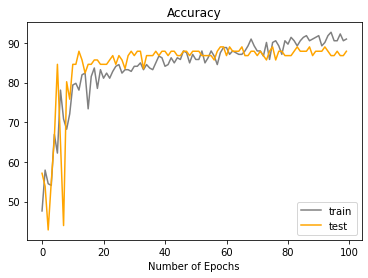

In [36]:
x = np.arange(num_epochs)
plt.title('Accuracy')
plt.plot(x, train_acc_new, label = 'train', color = 'gray')
plt.plot(x, test_acc_new, label = 'test', color = 'orange')
plt.xlabel('Number of Epochs')
plt.legend()

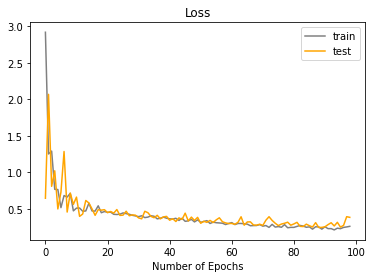

In [42]:
x = np.arange(99)
plt.title('Loss')
plt.plot(x, train_loss[1:], label = 'train', color = 'gray')
plt.plot(x, test_loss[1:], label = 'test', color = 'orange')
plt.xlabel('Number of Epochs')
plt.legend()

In [45]:
max(test_acc_new)

tensor(89.0110, dtype=torch.float64)

In [46]:
max(train_acc_new)

tensor(92.7039, dtype=torch.float64)